# Download packages

In [3]:
%pip install -U tensorly torch

  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 528.9 kB/s eta 0:00:0000:0100:04
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 573.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 466.4 kB/s eta 0:00:00:--:--
Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly import tenalg, tucker_to_tensor

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [96]:
tl.set_backend('numpy')

In [98]:
seed = 42

tl.check_random_state(seed)
np.random.seed(seed)

# Algoritm using article idea

In [8]:
# Входные данные
I, J, K = 5, 5, 5
X_tensor = tl.tensor(np.random.rand(I, J, K), dtype=tl.float32)
epsilon = 1e-5

# Инициализация
k = 0
R_n = [min(I, J, K)] * 3
r = np.linalg.norm(X_tensor)
r_prev = r + 2 * epsilon  # Инициализируем, чтобы войти в цикл

while abs(r_prev - r) >= epsilon and min(R_n) > 1:
    U = []
    for n in range(3):
        # Раскладываем тензор по n-му измерению
        Xn = tl.unfold(X_tensor, n)
        
        # Вычисляем SVD разложение
        U_n, S, Vh = np.linalg.svd(Xn, full_matrices=False)
        
        # Берем первые R_n[n] левых сингулярных векторов
        rank = R_n[n]
        U_n = U_n[:, :rank]
        U.append(U_n)
        
        # Обновляем ранги
        R_n[n] = max(R_n[n] - 1, 1)
    
    k += 1
    
    # Вычисляем ядро G_k
    G_k = tenalg.multi_mode_dot(X_tensor, [U_n.T for U_n in U], modes=[0, 1, 2])
    
    # Вычисляем приближенный тензор
    X_approx = tenalg.multi_mode_dot(G_k, U, modes=[0, 1, 2])
    
    # Обновляем критерий остановки
    r_prev = r
    r = np.linalg.norm(X_tensor - X_approx)
    print(f"Iteration {k}, residual r = {r}")
    
# Возвращаем результаты
G_hat = G_k
A_hat, B_hat, C_hat = U

print("Ĝ shape:", G_hat.shape)
print("Â shape:", A_hat.shape)
print("B̂ shape:", B_hat.shape)
print("Ĉ shape:", C_hat.shape)

Iteration 1, residual r = 6.304188673311728e-07
Iteration 2, residual r = 1.4040411710739136
Iteration 3, residual r = 2.148277521133423
Iteration 4, residual r = 2.459545373916626
Ĝ shape: (2, 2, 2)
Â shape: (5, 2)
B̂ shape: (5, 2)
Ĉ shape: (5, 2)


In [108]:
# Восстанавливаем тензор из разложения
X_approx = tenalg.multi_mode_dot(G_hat, [A_hat, B_hat, C_hat], modes=[0, 1, 2])
# X_approx = tucker_to_tensor((G_hat, factors))

# Вычисляем ошибку восстановления
reconstruction_error = np.linalg.norm(X_tensor - X_approx) / np.linalg.norm(X_tensor)
print("Ошибка восстановления:", reconstruction_error)

Ошибка восстановления: 0.4250235


In [142]:
# Восстанавливаем тензор из разложения
X_approx = tenalg.multi_mode_dot(G_hat, [A_hat, B_hat, C_hat], modes=[0, 1, 2])
# X_approx = tucker_to_tensor((G_hat, factors))

# Вычисляем ошибку восстановления
reconstruction_error = np.linalg.norm(X_tensor - X_approx) / np.linalg.norm(X)
print("Ошибка восстановления:", reconstruction_error)

Ошибка восстановления: 0.4342463


# Use Tucker tensorly 

In [12]:
# Входные данные
I, J, K = 5, 5, 5
X_tensor = np.random.rand(I, J, K)
epsilon = 1e-5
seed = 42

# Задаем ранги по каждому измерению
# # ranks = [min(I, J, K), min(I, J, K), min(I, J, K)]

# Задаем ранги по каждому измерению меньше исходных размеров
ranks = [2, 2, 2]  # Задайте желаемые ранги

# Выполняем Tucker разложение
G_hat, factors = tucker(X_tensor, rank=ranks, tol=epsilon, random_state=seed)

# Разбираем факторы
A_hat, B_hat, C_hat = factors

# Выводим результаты
print("Ĝ shape:", G_hat.shape)
print("Â shape:", A_hat.shape)
print("B̂ shape:", B_hat.shape)
print("Ĉ shape:", C_hat.shape)

Ĝ shape: (2, 2, 2)
Â shape: (5, 2)
B̂ shape: (5, 2)
Ĉ shape: (5, 2)


In [13]:
# Восстанавливаем тензор из разложения
X_approx = tenalg.multi_mode_dot(G_hat, [A_hat, B_hat, C_hat], modes=[0, 1, 2])
# X_approx = tucker_to_tensor((G_hat, factors))

# Вычисляем ошибку восстановления
reconstruction_error = np.linalg.norm(X_tensor - X_approx) / np.linalg.norm(X_tensor)
print("Ошибка восстановления:", reconstruction_error)

Ошибка восстановления: 0.4343093142612414


In [4]:
# SVD CLASS
'''
This class takes the SVD (np.linalg.svd) of an input matrix.
It also contains some built-in functions to visualize the SVD
'''
class SVD:
    def __init__(self, mat, s_as_array=False, full_matrices=True):     
        self.mat = mat
        self.s_as_array = s_as_array
        self.full_matrices = full_matrices
        
        if s_as_array:
            self.U, self.S, self.Vt, self.S_arr = self.svd(self.mat, self.s_as_array, self.full_matrices)
        else:
            self.U, self.S, self.Vt = self.svd(self.mat, self.s_as_array, self.full_matrices)
        
    def svd(self, mat, s_as_array=False, full_matrices=True):
        '''
        Performs the SVD on a matrix
        OUTPUTS: U, S, and Vt as matrices
        '''
        # Take SVD of input matrix
        U, S_arr, V = np.linalg.svd(mat, full_matrices)

        # Turn array into full S matrix
        S = np.zeros((U.shape[1], V.shape[0]))
        S[:S_arr.size, :S_arr.size] = np.diag(S_arr)

        if s_as_array:
            return U, S, V, S_arr
        else:
            return U, S, V
    def ReturnVals(self):
        if self.s_as_array:
            return self.U, self.S, self.Vt, self.S_arr
        else:
            return self.U, self.S, self.Vt

    def Visualize(self, params={}, num_vt_rows=3, aspect_mult=1, contrast=1):
        '''
        Visualizes the SVD by showing a 3x1 subplot
        with raster plot of U, bar chart of S, and line graph of rows in Vt
        '''
        # Unpack the parameters (if I want to plut a subset of the matrices, for example)
        if 'U' in params:
            U = params['U']
        else:
            U = self.U
        if 'S' in params:
            S = params['S']
        else:
            S = self.S
        if 'Vt' in params:
            Vt = params['Vt']
        else:
            Vt = self.Vt
        # no condition here for unexpected keys...
            
        # Prepare subplots
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        plt.tight_layout()

        # U matrix (Raster plot)
        raster = self.RasterPlot(U, plot=False)
        ax[0].imshow(raster)
        ax[0].set_title("U")
        forceAspect(ax[0],aspect=aspect_mult*1.618033988749894)

        # S matrix (horizontal bar chart)
        pos = np.arange(np.shape(S)[1])
        ax[1].barh(pos, np.diagonal(S), align='edge')
        ax[1].set_ylim(len(pos), 0)  
        ax[1].set_title("S")

        # Vt matrix (line graph of select rows)
        color = iter(cm.rainbow(np.linspace(0, 1, num_vt_rows)))
        for i in range(num_vt_rows):
            c = next(color)
            ax[2].plot(self.Vt[i, :], color=c, marker='.', label=str(i))
        ax[2].set_title("Vt")
        plt.legend()
        plt.show()
        
    def RasterPlot(self, matrix, contrast=1, aspect_multiplier = 1, plot=True):
        '''
        Creates a raster plot with RGB colors
        *Note for all positive data, this will create poor plots
        '''
        # Get the dimensions of the matrix
        rows, columns = matrix.shape

        # Define contrast
        contrast = contrast

        # Create raster array
        raster = np.zeros((rows, columns, 3))
        for a in range(rows):
            for b in range(columns):
                rgbRaster = contrast * matrix[a, b]
                if rgbRaster > 0:
                    raster[a, b] = [rgbRaster, 0, 0]
                else:
                    raster[a, b] = [0, -rgbRaster, 0]

        # Create the plot
        if plot:
            fig, ax = plt.subplots()
            # g = plt.imshow(np.flip(raster, 0), aspect='equal')
            g = plt.imshow(raster, aspect='equal')
            #plt.gca().set_aspect('equal', adjustable='box')
            #plt.gca().set_data_ratio(1.61803398874989)
            self.forceAspect(ax, aspect_multiplier*1.61803398874989)
            plt.show()
        return raster
    
    def forceAspect(self, ax, aspect=1):
        '''
        Use to make raster plots look less squished
        '''
        im = ax.get_images()
        extent =  im[0].get_extent()
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [5]:
class HOSVD3(SVD):
    '''
    Class for calculating the HOSVD of a 3-D tensor. Follows the work in De Lathauwer
    Contains functions to visualize and extract different components of the HOSVD
    '''
    
    def __init__(self, Tensor):
        '''
        Expects a tensor of form (I1, I2, I3) or (X, Y, Z) 
        '''
        self.A = Tensor
        self.debug = False
        
        # dimensions of tensor
        self.I1, self.I2, self.I3 = self.TensorDimensions()
        
        # unfolded tensor
        self.A1 = None
        self.A2 = None
        self.A3 = None 

        # HOSVD unitary matrices
        self.U1 = None
        self.U2 = None
        self.U3 = None
        
        # HOSVD core
        self.S = None
        
        print('Tensor created, ready to decompose')
        print()
        
    def TensorDimensions(self):
        '''
        Extract the length of each dimension 
        '''
        s = self.A.shape
        return s[0], s[1], s[2]
    
    
    def Unfold(self):
        '''
        Unfolds the tensor into three matrices
        '''
        # A1
        self.A1 = tl.unfold(self.A, 0)
        if self.debug:
            print()
            print('Shape of A1: ', self.A1.shape)
            print('Expected Shape: ', (self.I1, self.I2*self.I3))
            
        # A2
        self.A2 = tl.unfold(self.A, 1)
        if self.debug:
            print()
            print('Shape of A2: ', self.A2.shape)
            print('Expected Shape: ', (self.I2, self.I1*self.I3))
        
        # A3      
        self.A3 = tl.unfold(self.A, 2)
        if self.debug:
            print()
            print('Shape of A3: ', self.A3.shape)
            print('Expected Shape: ', (self.I3, self.I1*self.I2))
            
    def GetU(self):
        '''
        Calculate the unitary matrices of the HOSVD (U^{(1)}, U^{(2)}, U^{(3)})
        '''
        # U1
        [self.U1, _, _] = super().svd(self.A1)
        
        if self.debug:
            print()
            print('Shape of U1: ', self.U1.shape)
            print('Expected Shape: ', (self.I1, self.I1))
            
        # U2
        [self.U2, _, _] = super().svd(self.A2)
        
        if self.debug:
            print()
            print('Shape of U2: ', self.U2.shape)
            print('Expected Shape: ', (self.I2, self.I2))
            
        # U3
        [self.U3, _, _] = super().svd(self.A3, full_matrices=False)
        
        if self.debug:
            print()
            print('Shape of U3: ', self.U3.shape)
            print('Expected Shape: ', (self.I3, self.I3))
        
    def GetS(self):
        '''
        Computes the core, S, of the tensor
        '''
        # compute the core unfolded in direction 1 (S_{(1)})
        S1 = np.dot(self.U1.T, np.dot(self.A1, np.kron(self.U2, self.U3)))
        L = np.shape(S1)[1]

        # Refold the core
        self.S = tl.fold(S1, 0, (self.I1, self.I2, self.I3))
        
        if self.debug:
            print()
            print('Shape of Core: ', self.S.shape)
            print('Expected shape: ', (self.I1, self.I2, self.I3))
    
    def PerformHOSVD(self):
        self.Unfold()
        self.GetU()
        self.GetS()

    def Check(self, unfold_dim='all'):
        '''
        Performs some tests to evaluate the algorithm's accuracy. 
        Can take some time to compute. Recommend using on 1 or 2 unfoldings
        '''
        # verify Unfolded matrices
        if unfold_dim == 'all':
            self.A1_check = np.dot(self.U1, np.dot(tl.unfold(self.S, 0), np.kron(self.U2, self.U3).T))
            self.A2_check = np.dot(self.U2, np.dot(tl.unfold(self.S, 1), np.kron(self.U1, self.U3).T))
            self.A3_check = np.dot(self.U3, np.dot(tl.unfold(self.S, 2), np.kron(self.U1, self.U2).T))
           
            print()
            print("Verifying work using De Lathauwer's equation 15:")
            print("\tA1 matches equation?", np.allclose(self.A1_check, self.A1))
            print("\tA2 matches equation?", np.allclose(self.A2_check, self.A2))
            print("\tA3 matches equation?", np.allclose(self.A3_check, self.A3))
            
        elif unfold_dim == 0:
            self.A1_check = np.dot(self.U1, np.dot(tl.unfold(self.S, 0), np.kron(self.U2, self.U3).T))
            print()
            print("Verifying work using De Lathauwer's equation 15:")
            print("\tA1 matches equation?", np.allclose(self.A1_check, self.A1))
            
        elif unfold_dim == 1:
            self.A2_check = np.dot(self.U2, np.dot(tl.unfold(self.S, 1), np.kron(self.U1, self.U3).T))
            print()
            print("Verifying work using De Lathauwer's equation 15:")
            print("\tA2 matches equation?", np.allclose(self.A2_check, self.A2))
            
        elif unfold_dim == 2:
            self.A3_check = np.dot(self.U3, np.dot(tl.unfold(self.S, 2), np.kron(self.U1, self.U2).T))
            print()
            print("Verifying work using De Lathauwer's equation 15:")
            print("\tA3 matches equation?", np.allclose(self.A3_check, self.A3))
            
    # Visualization Functions
    def ShowUnfoldings(self, aspect_mult=1, contrast=1):
        # Prepare subplots
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        plt.tight_layout()

        # A1 (Raster plot)
        raster = super().RasterPlot(self.A1, plot=False, contrast=contrast)
        ax[0].imshow(raster)
        ax[0].set_title("A1")
        super().forceAspect(ax[0],aspect=aspect_mult*1.618033988749894)

        # A2 (Raster plot)
        raster = super().RasterPlot(self.A2, plot=False, contrast=contrast)
        ax[1].imshow(raster)
        ax[1].set_title("A2")
        super().forceAspect(ax[1],aspect=aspect_mult*1.618033988749894)
        
        # A3 (Raster plot)
        raster = super().RasterPlot(self.A3, plot=False, contrast=contrast)
        ax[2].imshow(raster)
        ax[2].set_title("A3")
        super().forceAspect(ax[2],aspect=aspect_mult*1.618033988749894)
        plt.show()
    
    def ShowU(self, aspect_mult=1, contrast=1):
        # Prepare subplots
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        plt.tight_layout()

        # A1 (Raster plot)
        raster = super().RasterPlot(self.U1, plot=False, contrast=contrast)
        ax[0].imshow(raster)
        ax[0].set_title("U1")
        super().forceAspect(ax[0],aspect=aspect_mult*1.618033988749894)

        # A2 (Raster plot)
        raster = super().RasterPlot(self.U2, plot=False, contrast=contrast)
        ax[1].imshow(raster)
        ax[1].set_title("U2")
        super().forceAspect(ax[1],aspect=aspect_mult*1.618033988749894)
        
        # A3 (Raster plot)
        raster = super().RasterPlot(self.U3, plot=False, contrast=contrast)
        ax[2].imshow(raster)
        ax[2].set_title("U3")
        super().forceAspect(ax[2],aspect=aspect_mult*1.618033988749894)
        plt.show()
    
    def ShowS(self, unfold_dim=0, aspect_mult=1, contrast=1):
        plt.figure(figsize=(12, 4))
        ax = plt.gca()
        raster = super().RasterPlot(tl.unfold(self.S, unfold_dim), plot=False, contrast=contrast)
        plt.imshow(raster)
        super().forceAspect(ax,aspect=aspect_mult*1.618033988749894)
        #plt.colorbar()
        plt.title(f'$S_{unfold_dim}$')
        plt.show()  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.7344221590617415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.7344221590617415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.7344221590617415].


Tensor created, ready to decompose



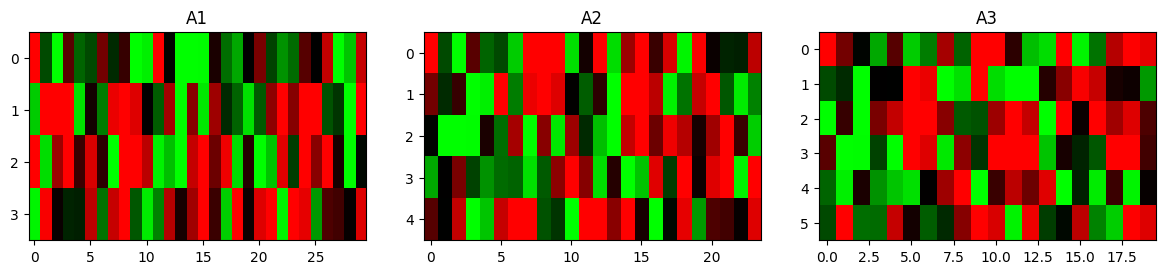

In [6]:
# Create a random tensor of shape (4, 5, 6)
tensor = np.random.randn(4, 5, 6)

# Initialize HOSVD class
hosvd_instance = HOSVD3(tensor)

# Perform HOSVD
hosvd_instance.PerformHOSVD()

# Visualize unfolded matrices
hosvd_instance.ShowUnfoldings()

In [9]:
# Пример тензора размером (4, 5, 6)
tensor = np.random.randn(4, 5, 6)

# Создаем экземпляр класса HOSVD3
hosvd_instance = HOSVD3(tensor)

# Выполняем HOSVD
hosvd_instance.PerformHOSVD()

# Получаем результаты разложения
U1, U2, U3 = hosvd_instance.U1, hosvd_instance.U2, hosvd_instance.U3
core_tensor = hosvd_instance.S

print("U1 matrix:\n", U1.shape)
print("U2 matrix:\n", U2.shape)
print("U3 matrix:\n", U3.shape)
print("Core tensor:\n", core_tensor.shape)

Tensor created, ready to decompose

U1 matrix:
 (4, 4)
U2 matrix:
 (5, 5)
U3 matrix:
 (6, 6)
Core tensor:
 (4, 5, 6)


In [10]:
# Восстанавливаем тензор с использованием ядра и матриц U1, U2, U3
reconstructed_tensor = tl.tenalg.multi_mode_dot(core_tensor, [U1, U2, U3], modes=[0, 1, 2])

print("Reconstructed tensor:\n", reconstructed_tensor)
print()
print("Is the reconstruction close to the original tensor?", np.allclose(tensor, reconstructed_tensor))
reconstruction_error = np.linalg.norm(tensor - reconstructed_tensor) / np.linalg.norm(tensor)
print("Ошибка восстановления:", reconstruction_error)

Reconstructed tensor:
 [[[-0.47738173 -0.66422744  1.36011137 -2.03707593  1.57003228
   -0.30232424]
  [-0.00456283 -0.6823426  -0.04819549  1.27113823  0.7708631
    0.49268648]
  [ 0.08887301 -1.44560997 -0.84413691 -0.34320124  0.45767645
    0.06965266]
  [ 0.98350431  0.47362739  0.05435058  2.2757613   0.40622669
   -0.4319422 ]
  [ 1.85996701  1.20041155  1.81608779 -0.11093194  0.97630913
   -1.45284946]]

 [[ 0.78400641 -0.15772396 -1.35505796  1.0326004  -1.81013132
   -1.91270652]
  [ 0.36247646  0.57134751  0.97052382  0.74196302  1.47665863
    0.70024295]
  [-0.13229944 -0.07361112 -0.28222119  0.29547752 -1.09734587
    0.3409222 ]
  [-0.08641351  0.27563516  0.27872303 -2.4522646  -0.90129382
   -0.10862866]
  [-0.05548496  0.25938931  0.30234829  1.51623332  0.31245848
   -0.31302371]]

 [[-1.59912347 -1.36859012  0.53549181  1.06044681  1.541371
   -0.82789308]
  [-0.30386444  0.24233369  2.04739892  0.11486147  1.55126285
    0.1699729 ]
  [ 1.15324519  1.02657985  